# HW3 Image Classification

Solve image classification with convolutional neural networks(CNN).
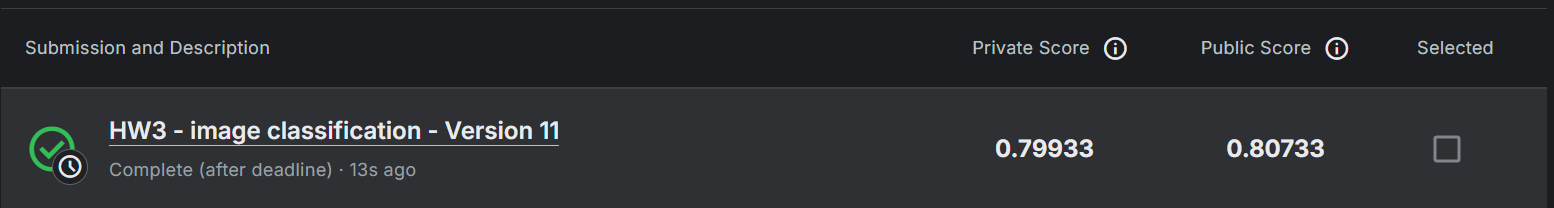

In [2]:
import numpy as np 
import pandas as pd 
import os
import torch
import random
import pandas as pd
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from PIL import Image
from torch.utils.tensorboard import SummaryWriter
from sklearn.model_selection import StratifiedKFold  
from matplotlib import pyplot as plt
from tqdm.auto import tqdm
#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))
from sklearn.manifold import TSNE
import matplotlib.cm as cm

2024-08-12 15:35:30.489841: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-12 15:35:30.490052: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-12 15:35:30.698863: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
def random_seeds(seed):
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

## Dataset of Food

In [4]:
class FoodDataset():
    def __init__(self,path,types,transform,labels = None):
        self.path = path
        path = path +types
        #print(path)
        files = sorted([os.path.join(path,x) for x in os.listdir(path) if x.endswith('.jpg')])
        if files is not None:  
            self.files = files 
        if labels is not None:
            self.labels = [int(fname.split('/')[-1].split('_')[0]) for fname in self.files]
        else:
            self.labels = None
        self.transform = transform
    
    def __len__(self):
        return len(self.files)
    
    def __getitem__(self,idx):
        item = self.files[idx]
        im = Image.open(item)
        im = self.transform(im)
        if self.labels is None:
            return im,-1
        else:
            return im,self.labels[idx]
    

## Data Augmention & Visualization

In [5]:
train_tfm = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.RandomChoice(transforms=[
        transforms.RandomHorizontalFlip(p=1),
        transforms.TrivialAugmentWide(),
        transforms.Lambda(lambda x: x),
    ],p=[0.05,0.9,0.05]),
    transforms.ToTensor(),
])

test_tfm = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor(),
])

In [7]:
image = Image.open("/kaggle/input/ml2023spring-hw3/valid/6_540.jpg")
def plot(imgs,with_orig=True, row_title=None, **imshow_kwargs):
    if not isinstance(imgs[0], list):
        # Make a 2d grid even if there's just 1 row
        imgs = [imgs]
    num_rows = len(imgs)
    num_cols = len(imgs[0]) + with_orig
    fig, axs = plt.subplots(nrows=num_rows, ncols=num_cols, squeeze=False)
    for row_idx, row in enumerate(imgs):          #row是图像列表
        row = [image] + row if with_orig else row
        for col_idx, img in enumerate(row):
            ax = axs[row_idx, col_idx]
            ax.imshow(np.asarray(img), **imshow_kwargs)
            ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

    if with_orig:
        axs[0, 0].set(title='Original image')
        axs[0, 0].title.set_size(8)
    if row_title is not None:
        for row_idx in range(num_rows):
            axs[row_idx, 0].set(ylabel=row_title[row_idx])

    plt.tight_layout()

def transform_and_plot(image):
    demo = [train_tfm(image) for i in range(5)]
    PIL_img_demo = [Image.fromarray(np.moveaxis(i.numpy()*255,0,-1).astype(np.uint8)) for i in demo]
    plot(PIL_img_demo)

## Model 

In [6]:
class Classifier(nn.Module):
    def __init__(self,input_dim=128):
        super(Classifier,self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(3,64,3,1,1), #[64,128,128]
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2,2,0), #[64,64,64]
            
            nn.Conv2d(64,128,3,1,1), #[128,64,64]
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2,2,0), #[128,32,32]
            
            nn.Conv2d(128,256,3,1,1), #[256,32,32]
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2,2,0),  #[256,16,16]
            
            nn.Conv2d(256,512,3,1,1), #[512,16,16]
            nn.BatchNorm2d(512), 
            nn.ReLU(),
            nn.MaxPool2d(2,2,0), #[512,8,8]
            
            nn.Conv2d(512,256,3,1,1), #[256,8,8]
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2,2,0), #[256,4,4]
            
        )
        
        self.fc = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(256*4*4,1024),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(1024,512),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(512,11)
        )
        
    def forward(self,x):
            out = self.cnn(x)
            out = out.view(out.size()[0],-1)
            return self.fc(out)
        
class DenseNet121(nn.Module):
    def __init__(self):
        super(DenseNet121, self).__init__()
        self.model = densenet121(weights=None)
        num_features = self.model.classifier.in_features
        self.model.classifier = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(num_features, 1024),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(512, 11)
        )

    def forward(self, x):
        x = self.model(x)
        return x

class ResNet50(nn.Module):
    def __init__(self):
        super(ResNet50, self).__init__()
        self.cnn = nn.Sequential(*list(resnet50(weights=None).children())[:-1])
        num_features = resnet50(weights=None).fc.in_features
        self.fc = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(num_features, 1024),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(512, 11)
        )
        
    
    def forward(self, x):
        out = self.cnn(x)
        out = out.view(out.size()[0], -1)
        return self.fc(out)

## Configurations

In [7]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
_exp_name = "sample"
criterion = nn.CrossEntropyLoss(label_smoothing=0.05)
model = Classifier().to(device) # model也要to(device)

batch_size = 32
num_epochs = 160
patience = 20
learning_rate = 1e-4
seeds = random_seeds(520)
file_path = "/kaggle/input/ml2023spring-hw3/"
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate,weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,mode='max',factor=0.8,patience=10,threshold=0.05)

## Dataloader

In [14]:
train_data = FoodDataset(file_path,'train',train_tfm,True)
valid_data = FoodDataset(file_path,'valid',train_tfm,True)
test_data = FoodDataset(file_path,'test',test_tfm)
train_loader = DataLoader(train_data,batch_size=batch_size,shuffle=True,pin_memory=True)
valid_loader = DataLoader(valid_data,batch_size=batch_size,shuffle=True,pin_memory=True)
test_loader = DataLoader(test_data,batch_size=batch_size,shuffle=False,pin_memory=True)

## Training！

In [15]:
writer = SummaryWriter()
train_acc = []
valid_acc = []
k = 5
# skf = StratifiedKFold(n_splits=k,shuffle=True,random_state=42)
best_acc = 0.0
'''
for fold,(train_idx, valid_idx) in enumerate(skf.split(train_dataset.indices, train_dataset.targets)):  
    print(f'Fold {fold+1}')  
    train_sampler = torch.utils.data.SubsetRandomSampler(train_idx)  
    valid_sampler = torch.utils.data.SubsetRandomSampler(valid_idx)
    
    train_loader = DataLoader(train_data, batch_size=batch_size, sampler=train_sampler)  
    valid_loader = DataLoader(valid_data, batch_size=batch_size, sampler=valid_sampler)  
 '''
train_loss_every_epoch = 0.0
train_acc_every_epoch = 0.0
val_loss_every_epoch = 0.0
val_acc_every_epoch = 0.0
for epoch in range(num_epochs):
    model.train()
    train_loss = []
    train_accs = []
    for batch in tqdm(train_loader):
        optimizer.zero_grad()
        imgs,labels = batch
        labels = labels.to(device)
        #print(type(imgs))
        imgs = imgs.to(device)
        outputs = model(imgs)
        loss = criterion(outputs,labels)
        loss.backward()
        optimizer.step()
        acc = (outputs.argmax(dim=-1) == labels).float().mean()
        train_loss.append(loss.item())
        train_accs.append(acc)
        
    train_loss_every_epoch = (sum(train_loss)/len(train_loss))
    train_acc_every_epoch = (sum(train_accs)/len(train_accs))
    print(f'[Train|{epoch+1:03d}/{num_epochs:03d}] Loss :{train_loss_every_epoch:.4f} , acc:{train_acc_every_epoch:.4f}')
        
    model.eval()
    val_loss = []
    val_accs = []
    for batch in tqdm(valid_loader):
        imgs,labels = batch
        labels = labels.to(device)
        imgs = imgs.to(device)
        with torch.no_grad():
            outputs = model(imgs)
            loss = criterion(outputs,labels)
            acc = (outputs.argmax(dim=-1) == labels).float().mean()
            val_loss.append(loss.item())
            val_accs.append(acc)
            
    val_loss_every_epoch=sum(val_loss)/len(val_loss)
    val_acc_every_epoch=sum(val_accs)/len(val_accs)
        
        
    print(f'[Valid|{epoch+1:03d}/{num_epochs:03d}] Loss :{val_loss_every_epoch:.4f} , acc:{val_acc_every_epoch:.4f}')
    
    writer.add_scalar('Acc/train',train_acc_every_epoch,epoch)
    writer.add_scalar('Acc/valid',val_acc_every_epoch,epoch)
    writer.add_scalar('lr',optimizer.state_dict()['param_groups'][0]['lr'],epoch)
    valid_acc = val_acc_every_epoch
    valid_loss = val_loss_every_epoch
    # Update logs
    if valid_acc > best_acc:
        with open(f"./{_exp_name}_log.txt","a"):
            print(f"[ Valid | {epoch + 1:03d}/{num_epochs:03d} ] loss = {valid_loss:.5f}, acc = {valid_acc:.5f} -> best")
    else:
        with open(f"./{_exp_name}_log.txt","a"):
            print(f"[ Valid | {epoch + 1:03d}/{num_epochs:03d} ] loss = {valid_loss:.5f}, acc = {valid_acc:.5f}")


    # Save models
    if valid_acc > best_acc:
        print(f"Best model found at epoch {epoch}, saving model")
        torch.save(model.state_dict(), f"{_exp_name}_best.ckpt") # only save best to prevent output memory exceed error
        best_acc = valid_acc
        stale = 0
    else:
        stale += 1
        if stale > patience:
            print(f"No improvment {patience} consecutive epochs, early stopping")
            break

    # Update learning rate based on the best_acc so far
    scheduler.step(best_acc)
    

  0%|          | 0/313 [00:00<?, ?it/s]

<class 'torch.Tensor'>
<class 'torch.Tensor'>


KeyboardInterrupt: 

## Test

In [11]:
model_best = Classifier().to(device)
model_best.load_state_dict(torch.load(f"{_exp_name}_best.ckpt"))
model_best.eval()
prediction = []
with torch.no_grad():
    for data,_ in tqdm(test_loader):
        data = data.to(device)
        test_prediction = model_best(data)
        test_label = np.argmax(test_prediction.cpu().data.numpy(),axis=1)
        prediction += test_label.squeeze().tolist()
        

FileNotFoundError: [Errno 2] No such file or directory: 'sample_best.ckpt'

In [12]:
def pad4(i):
    return "0"*(4-len(str(i))) + str(i)
df = pd.DataFrame()
df["Id"] = [pad4(i) for i in range(len(test_data))]
df["Category"] = prediction
df.to_csv("submission.csv",index=False)
print(model_best)

NameError: name 'prediction' is not defined

## painting

In [12]:
# Load the vaildation set defined by TA
valid_set = FoodDataset(file_path,'valid',transform=test_tfm)
valid_loader = DataLoader(valid_set, batch_size=64, shuffle=False, num_workers=0, pin_memory=True)
print(type(valid_loader))
# Extract the representations for the specific layer of model
index = 17 # You should find out the index of layer which is defined as "top" or 'mid' layer of your model.
features = []
labels = []
for batch in tqdm(valid_loader):
    imgs, lbls = batch
    with torch.no_grad():
        print(type(imgs))
        imgs = imgs.to(device)
        logits = model.cnn[:index](imgs)
        logits = logits.view(logits.size()[0], -1)
    labels.extend(lbls.cpu().numpy())
    logits = np.squeeze(logits.cpu().numpy())
    features.extend(logits)
    
features = np.array(features)
colors_per_class = cm.rainbow(np.linspace(0, 1, 11))

# Apply t-SNE to the features
features_tsne = TSNE(n_components=2, init='pca', random_state=42).fit_transform(features)

# Plot the t-SNE visualization
plt.figure(figsize=(10, 8))
for label in np.unique(labels):
    plt.scatter(features_tsne[labels == label, 0], features_tsne[labels == label, 1], label=label, s=5)
plt.legend()
plt.show()

<class 'torch.utils.data.dataloader.DataLoader'>


  0%|          | 0/57 [00:00<?, ?it/s]

<class 'tuple'>


AttributeError: 'tuple' object has no attribute 'to'

In [2]:
!ls